In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from diagnostics.inventory import ModelInventoryBuilder, QueryBuilder

In [2]:
# prompt to specify directory containing config files
artifacts_path  = input("Please enter path to artifacts, no quotation marks: ")
print("Searching for models in %s" % artifacts_path)
assert os.path.isdir(artifacts_path)


Searching for models in /home/jovyan/grid_artifacts/mirror-fish


Steps:
1. load our hydra cfg (start with 1 and extend)
2. flatten hierarchy.
3. make into a df (optionally append more).
4. build queries.


In [3]:
model_inventory = ModelInventoryBuilder(artifacts_path)

In [4]:
total_df = model_inventory.build_dframe()

Building model registry from 114 configs...


100%|██████████| 114/114 [00:03<00:00, 35.86it/s]


In [7]:
query_builder = QueryBuilder(total_df)
# query_builder.add_query("training.rng_seed_data_pt", "in", ["0", "1","2"])
query_builder.add_query("training.train_frames", "in", ["75", "1"]) # try to grab both scarce and abundant labels 
# query_builder.add_query("training.train_frames", "==", "1") # # use just training.train_frames=1 for now
# query_builder.add_query("model.losses_to_use", "==", "[]") # works
# query_builder.add_query("model.losses_to_use", "==", "['unimodal_mse']") # works
# query_builder.add_query("model.do_context", "==", "True") # works
query_builder.add_query("model.losses_to_use", "in", ["[]", "[pca_multiview]"]) # trying to grab both unimodal_mse and supervised. note no quotes inside brackets per loss
query_builder.add_timestamp_query("2022-12-15", "2022-12-24") # works
# query_builder.add_query("model.model_type", "==", "heatmap_mhcrnn")
# pca_singleview log weight above 4
# query_builder.add_query("losses.pca_multiview.log_weight", ">", 3.) 
print(query_builder.combine_queries("and"))

`training.train_frames` == '75' or `training.train_frames` == '1'
`model.losses_to_use` == '[]' or `model.losses_to_use` == '[pca_multiview]'
(`training.train_frames` == '75' or `training.train_frames` == '1') and (`model.losses_to_use` == '[]' or `model.losses_to_use` == '[pca_multiview]') and (timestamp >= '2022-12-15' and timestamp <= '2022-12-24')


In [8]:
total_df_queried = total_df.query(query_builder.combine_queries("and"))
total_df_queried.shape

(42, 91)

In [9]:
def load_pred_csvs(filename, metric_name, split_set, pd_kwrgs) -> pd.DataFrame:
    df = pd.read_csv(filename, **pd_kwrgs)
    # take mean over all columns that are not "set"
    df["mean"] =  df.loc[:,[c for c in df.columns if c!= "set"]].mean(axis=1)
    if split_set is not None:
        df["set"] = split_set
    # add mean and metric
    df["metric"] = metric_name
    
    return df

In [10]:
# df = pd.read_csv(filename, header=[0], index_col=[0])
# print(df.columns)
# print(df["set"])
#  df.loc[:,[c for c in df.columns if c!= "yearID"]]
# [col is not "set" for col in df.columns.to_list()]

In [11]:
# loop over rows of df, load predictions_pixel_error.csv, predictions_pca_singleview_error.csv
df_list = []
loss_log_weights = total_df.columns[total_df.columns.str.contains("losses") & total_df.columns.str.contains("log_weight")].to_list()
for i, path in enumerate(total_df_queried["path"]):

    df_metric_list = []
    for metric_name in ["pixel_error", "pca_singleview_error", "pca_multiview_error"]:
        filename = os.path.join(path, "predictions_%s.csv" % metric_name)
        if os.path.isfile(filename):
            df = load_pred_csvs(filename, metric_name, None, pd_kwrgs={"header": [0], "index_col": 0})
            df_metric_list.append(df)
    
    df_ = pd.concat(df_metric_list) # concat to one df

    # add path
    df_["path"] = path
    # add rng_seed_data_pt
    df_["rng_seed_data_pt"] = total_df_queried.iloc[i]["training.rng_seed_data_pt"]
    # add train_frames
    df_["train_frames"] = total_df_queried.iloc[i]["training.train_frames"]

    # add log weight for all losses
    for log_weight in loss_log_weights:
        if  total_df_queried.iloc[i]["model.losses_to_use"] == "[]":
            df_[log_weight] = "100" # for supervised model, actually infinity
        else: 
            df_[log_weight] = total_df_queried.iloc[i][log_weight]

    df_list.append(df_)

# concat all dfs
df_big = pd.concat(df_list)


In [12]:
# input which hparam to sweep -- which log weight
hparam_name = input("Select hparam to sweep, e.g. losses.pca_multiview.log_weight (no quotes): ")
# input split set
split_set = input("Select split set, e.g. train, validation, test (no quotes): ")
# input dataset name
dataset_name = input("Select dataset name, e.g. mirror-mouse (no quotes): ")
# accordingly, get values and sort them and plot all existing metrics
values = df_big[hparam_name].unique()
values = sorted(values, key=lambda x: float(x))



In [13]:
print(hparam_name)
print(split_set)
print(dataset_name)
print(values)
# dataset_name = "mirror-mouse"
# sweep_name = "unimodal_mse"
# split_set = "validation"

losses.pca_multiview.log_weight
validation
mirror-fish
['4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '100']


In [14]:
df_big.shape

(42210, 54)

In [15]:
total_df_queried["data.image_orig_dims.height"].unique()

array(['384'], dtype=object)

In [16]:
threshold = 5. # pixels, beyond which we consider a prediction to be wrong

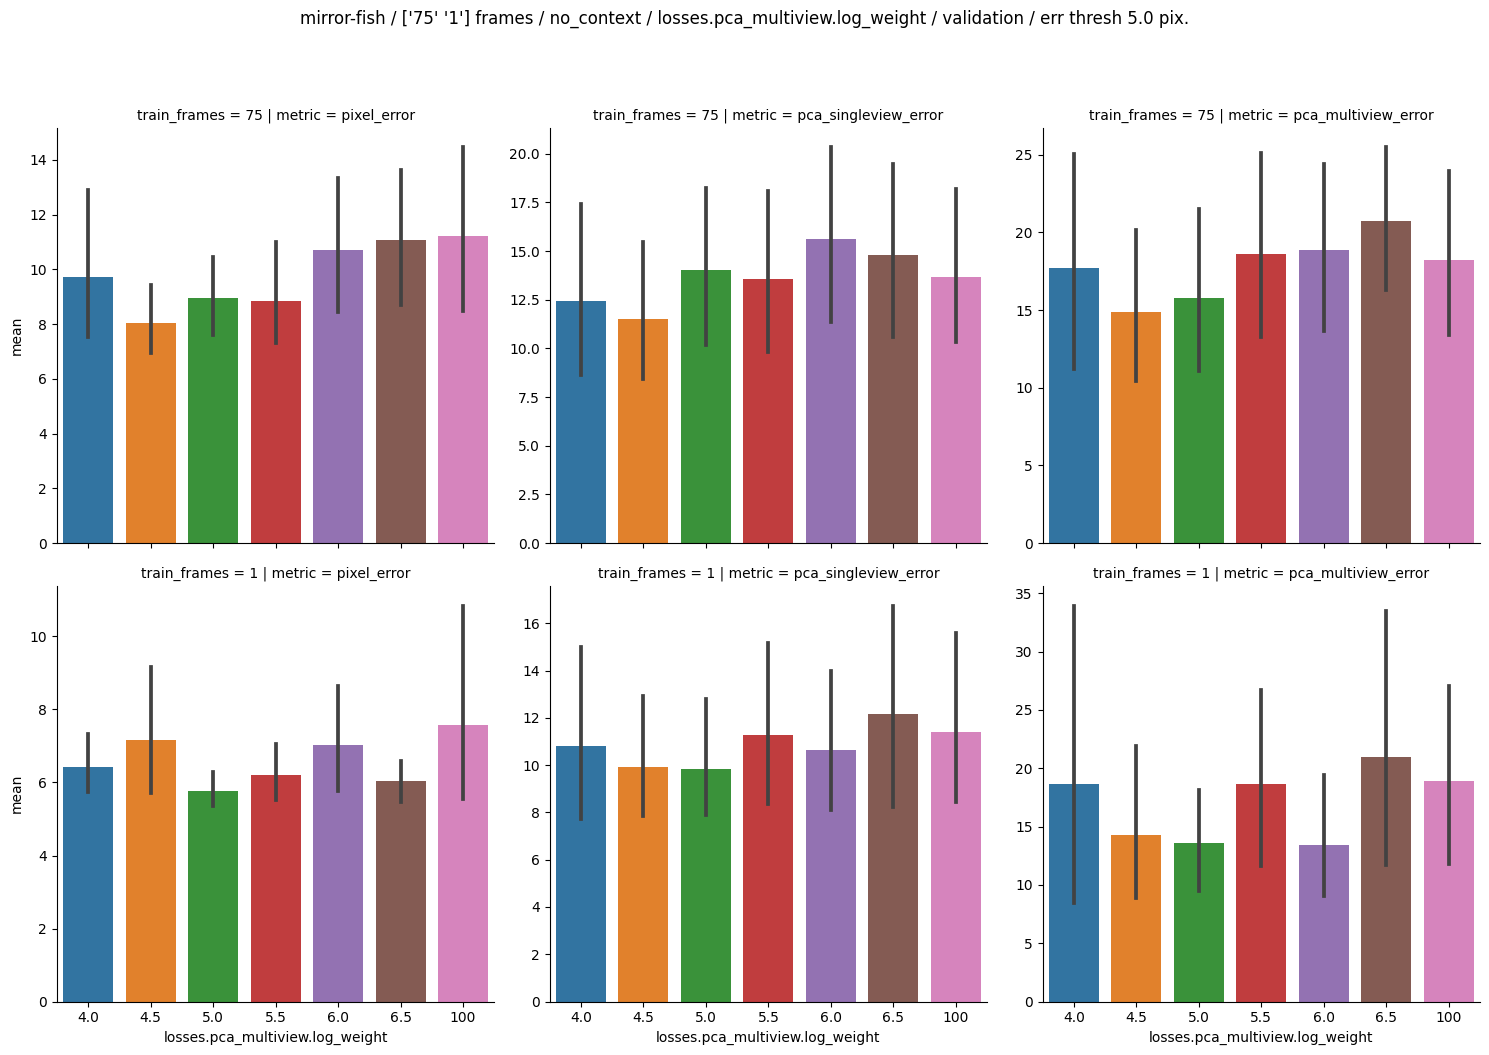

In [17]:
# plot bars with errors per rng seed, and two panels, one per metric
# sns.catplot(data=df_big_mean, x="rng_seed_data_pt", y="paw1LH_top", col="metric", ci="sd")
train_frames = total_df_queried["training.train_frames"].unique()
do_context = total_df_queried["model.do_context"].unique()[0] # assuming all models have same do_context
if do_context == True:
    context = "context"
else:
    context = "no_context"
# col_order= ["pixel_error", "pca_singleview_error", "pca_multiview_error"]
# if train_frames == "1":
#     train_frames = "full"


unique_metrics = df_big["metric"].unique().tolist()
col_order = ["pixel_error", "pca_singleview_error", "pca_multiview_error"]
row_order = ["75", "1"] # if change numbers in the future, change here too
# if element in col_order appears in unique_metrics, we keep it, otherwise we drop it
col_order = [metric for metric in col_order if metric in unique_metrics]
g = sns.catplot(data=df_big[(df_big["set"] == split_set) & (df_big["mean"]>threshold)], x=hparam_name, sharey=False, order=values, y="mean", row="train_frames", row_order=row_order, col="metric", col_order= col_order, errorbar=('ci', 95), kind="bar") # x="unimodal_mse_log_weight"
# add dataset name and sweep and split set to title
g.fig.suptitle(f"{dataset_name} / {train_frames} frames / {context} / {hparam_name} / {split_set} / err thresh {threshold} pix.", y=1.05)
g.fig.tight_layout()
# add horizontal line at 5 
# plt.axhline(y=5, color='r', linestyle='-')

In [ ]:
# plot bars with errors per rng seed, and two panels, one per metric
# sns.catplot(data=df_big_mean, x="rng_seed_data_pt", y="paw1LH_top", col="metric", ci="sd")
train_frames = total_df_queried["training.train_frames"].unique()
do_context = total_df_queried["model.do_context"].unique()[0] # assuming all models have same do_context
if do_context:
    context = "context"
else:
    context = "no_context"
# col_order= ["pixel_error", "pca_singleview_error", "pca_multiview_error"]
if train_frames == "1":
    train_frames = "full"


unique_metrics = df_big["metric"].unique().tolist()
col_order = ["pixel_error", "pca_singleview_error", "pca_multiview_error"]
# if element in col_order appears in unique_metrics, we keep it, otherwise we drop it
col_order = [metric for metric in col_order if metric in unique_metrics]
g = sns.catplot(data=df_big[(df_big["set"] == split_set) & (df_big["mean"]>threshold)], x=hparam_name, sharey=False, order=values, y="mean", col="metric", col_order= col_order, errorbar=('ci', 95), kind="bar") # x="unimodal_mse_log_weight"
# add dataset name and sweep and split set to title
g.fig.suptitle(f"{dataset_name} / {train_frames} frames / {context} / {hparam_name} / {split_set} / err thresh {threshold} pix.", y=1.05)
g.fig.tight_layout()
# add horizontal line at 5 
# plt.axhline(y=5, color='r', linestyle='-')

In [43]:
print(df_big[(df_big["set"] == split_set) & (df_big["mean"]>threshold) & (df_big["metric"] == "pixel_error")].groupby(hparam_name)["mean"].mean())
print(df_big[(df_big["set"] == split_set) & (df_big["mean"]>threshold) & (df_big["metric"] == "pixel_error")].groupby(hparam_name)["mean"].std())
print(df_big[(df_big["set"] == split_set) & (df_big["mean"]>threshold) & (df_big["metric"] == "pixel_error")].groupby(hparam_name)["mean"].count()


losses.pca_multiview.log_weight
100    5.220822
4.5    4.660349
5.0    4.801392
5.5    4.932942
6.0    5.141975
7.0    5.033962
Name: mean, dtype: float64
losses.pca_multiview.log_weight
100    2.849198
4.5    1.387386
5.0    1.360456
5.5    1.825879
6.0    2.551603
7.0    1.964657
Name: mean, dtype: float64
losses.pca_multiview.log_weight
100    99
4.5    99
5.0    99
5.5    99
6.0    99
7.0    99
Name: mean, dtype: int64


In [16]:
df_big["set"]

labeled-data/20201001_Hank/img008902.png     test
labeled-data/20201001_Hank/img026483.png    train
labeled-data/20201001_Hank/img033509.png    train
labeled-data/20201001_Hank/img045764.png    train
labeled-data/20201001_Hank/img052628.png     test
                                            ...  
labeled-data/20201224_Neil/img112080.png    train
labeled-data/20201224_Neil/img119060.png    train
labeled-data/20201224_Neil/img119310.png    train
labeled-data/20201224_Neil/img148890.png    train
labeled-data/20201224_Neil/img158830.png    train
Name: set, Length: 18090, dtype: object

In [17]:
# grouping by rng_seed_data_pt and hparam_name and metric, and then taking mean and std
df_big_mean = df_big.groupby(["rng_seed_data_pt", hparam_name, "metric", "set"]).mean().reset_index()
df_big_mean

/tmp/ipykernel_24311/3189459955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_big_mean = df_big.groupby(["rng_seed_data_pt", hparam_name, "metric", "set"]).mean().reset_index()


,rng_seed_data_pt,losses.pca_multiview.log_weight,metric,set,head_main,chin_base_main,chin1_4_main,chin_half_main,chin3_4_main,chin_tip_main,...,mid_right,fork_right,stripeA_right,stripeP_right,tail_neck_right,dorsal_right,anal_right,caudal_d_right,caudal_v_right,mean
0,0,100,pca_multiview_error,test,7.789767,10.051424,5.859006,13.943246,13.834253,11.517747,...,6.414339,7.450034,7.093236,3.740612,5.657844,4.572215,5.453432,7.683909,9.058194,9.460522
1,0,100,pca_multiview_error,train,2.968062,3.717474,4.425143,5.483123,6.485375,6.605881,...,6.921900,8.237724,6.001512,6.360794,6.855383,8.430656,9.205938,9.466798,9.953733,8.598898
2,0,100,pca_multiview_error,validation,3.612213,11.896049,10.648199,7.486427,12.823685,9.100009,...,3.199113,7.804650,3.225821,3.086973,3.089894,4.465754,6.258789,7.663689,10.543915,8.940174
3,0,100,pca_singleview_error,test,9.221445,NaN,NaN,NaN,NaN,NaN,...,12.289051,NaN,12.270571,NaN,NaN,9.686279,NaN,NaN,NaN,8.418918
4,0,100,pca_singleview_error,train,9.550168,NaN,NaN,NaN,NaN,NaN,...,9.699355,NaN,9.246171,NaN,NaN,12.584523,NaN,NaN,NaN,9.546034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2,7.0,pca_singleview_error,train,11.948278,NaN,NaN,NaN,NaN,NaN,...,7.192021,NaN,6.871248,NaN,NaN,10.502570,NaN,NaN,NaN,9.460714
158,2,7.0,pca_singleview_error,validation,8.761998,NaN,NaN,NaN,NaN,NaN,...,5.247852,NaN,4.939894,NaN,NaN,7.291000,NaN,NaN,NaN,6.308399
159,2,7.0,pixel_error,test,4.230118,4.199783,3.761089,3.937375,4.261264,4.410412,...,3.706669,4.348934,4.431821,4.305579,4.214629,3.925531,4.424060,5.684521,6.709311,5.531322
160,2,7.0,pixel_error,train,3.435487,3.624474,3.514406,3.541631,3.615715,3.570627,...,3.056492,2.942960,2.962168,2.813090,2.837215,2.495396,3.152265,2.656008,3.353942,3.123232


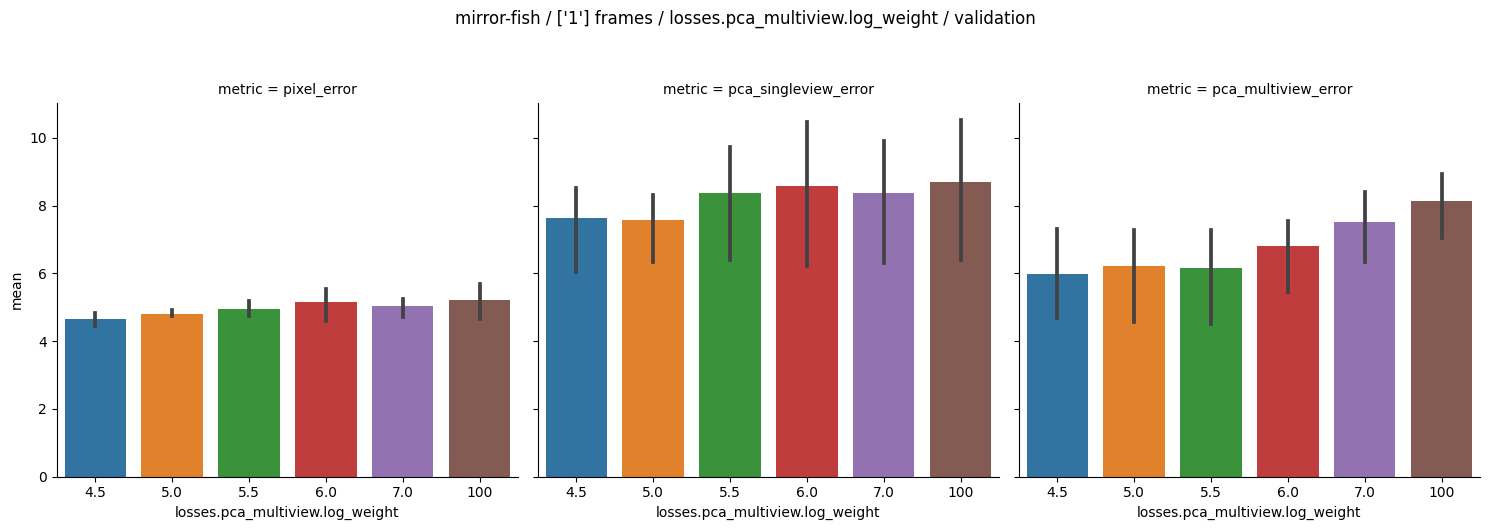

In [18]:
g = sns.catplot(data=df_big_mean[df_big_mean["set"] == split_set], x=hparam_name, col_order=["pixel_error", "pca_singleview_error", "pca_multiview_error"], order=values, y="mean", col="metric", errorbar=('ci', 95), kind="bar") # x="unimodal_mse_log_weight"
g.fig.suptitle(f"{dataset_name} / {train_frames} frames / {hparam_name} / {split_set}", y=1.05)
g.fig.tight_layout()
# sns.catplot(data=df_big_mean[df_big_mean["set"] == split_set], x=hparam_name, order=values, y="mean", col="metric", errorbar=('ci', 95)) # x="unimodal_mse_log_weight"



In [43]:
# df_big_mean.columns
# print(df_big.columns)
df_big_mean.columns

Index(['rng_seed_data_pt', 'losses.pca_multiview.log_weight', 'metric', 'set',
       'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top',
       'tailMid_top', 'nose_top', 'obs_top', 'paw1LH_bot', 'paw2LF_bot',
       'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot',
       'obsHigh_bot', 'obsLow_bot', 'mean'],
      dtype='object')

In [31]:
df_big.columns[df_big.columns.str.contains("set")]

Index(['set'], dtype='object')

In [44]:
df_big_mean.head()

,rng_seed_data_pt,losses.pca_multiview.log_weight,metric,set,paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top,tailBase_top,tailMid_top,...,paw1LH_bot,paw2LF_bot,paw3RF_bot,paw4RH_bot,tailBase_bot,tailMid_bot,nose_bot,obsHigh_bot,obsLow_bot,mean


In [ ]:
# in reality we always average over random seeds
# and we also average over all bodyparts
# then we have one number per index (and metric) which we can compute mean and std across

In [23]:
# builda a dataframe with the different metrics  for each model
pixel_error = pd.read_csv(os.path.join(total_df["path"].iloc[0], "predictions_pixel_error.csv"), header=[0], index_col=0)
pca_sv_error = pd.read_csv(os.path.join(total_df["path"].iloc[0], "predictions_pca_singleview_error.csv"), header=[0], index_col=0)
# concat dfs and add datasource 
# col1 col2 ... coln metric_name
pixel_error["metric_name"] = "pixel_error"
pixel_error
pca_sv_error["metric_name"] = "pca_sv_error"
metrics_df = pd.concat([pixel_error, pca_sv_error])
print(metrics_df.shape)
# metrics_df.head()
metrics_df.tail()


(1578, 18)


,paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top,tailBase_top,tailMid_top,nose_top,obs_top,paw1LH_bot,paw2LF_bot,paw3RF_bot,paw4RH_bot,tailBase_bot,tailMid_bot,nose_bot,obsHigh_bot,obsLow_bot,metric_name
labeled-data/180618_010/img015138.png,3.597447,9.845196,2.319927,5.746223,10.062808,6.068479,5.214673,NaN,2.713475,9.559510,3.589464,4.692842,3.156467,2.835987,4.193313,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015239.png,1.040644,7.150720,1.202592,4.670954,6.687197,3.449102,5.656707,NaN,4.015197,6.924648,2.004379,4.508363,1.449139,7.106095,5.712533,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015255.png,0.969156,1.107023,0.287090,0.386345,8.342234,3.844841,5.888730,NaN,1.731964,1.112309,0.606375,0.485698,3.845474,2.873000,6.867593,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015256.png,8.874399,4.952618,0.695706,4.410593,9.027818,4.032358,5.565386,NaN,8.464097,3.961636,1.494496,4.269255,2.836296,4.759048,4.074685,NaN,NaN,pca_sv_error
labeled-data/180618_010/img015397.png,1.563273,0.466724,0.508362,1.632182,6.238623,2.623401,5.355439,NaN,2.383311,0.792233,0.083734,1.791323,5.436836,4.716587,5.487217,NaN,NaN,pca_sv_error


## what do we want to plot per sweep
- the mean and error bars are over rng seeds if these exist.
- we have cols per metric
- x axis is over the quantity we are sweeping over -- log weight? this has to be specified before plotting. 
- y axis is over the metric we are plotting (bodypart specific or mean over all bodyparts)
This is for selecting hparams, no need to dive into bodypart performance or scatter plots.

Text(0.5, 1.0, 'dataset: /Users/danbiderman/Dropbox/Columbia/1.Dan/Research/grid_artifacts/urban-chebyshev-5171/urban-chebyshev-5171-exp1/outputs/2022-11-15/15-55-27')

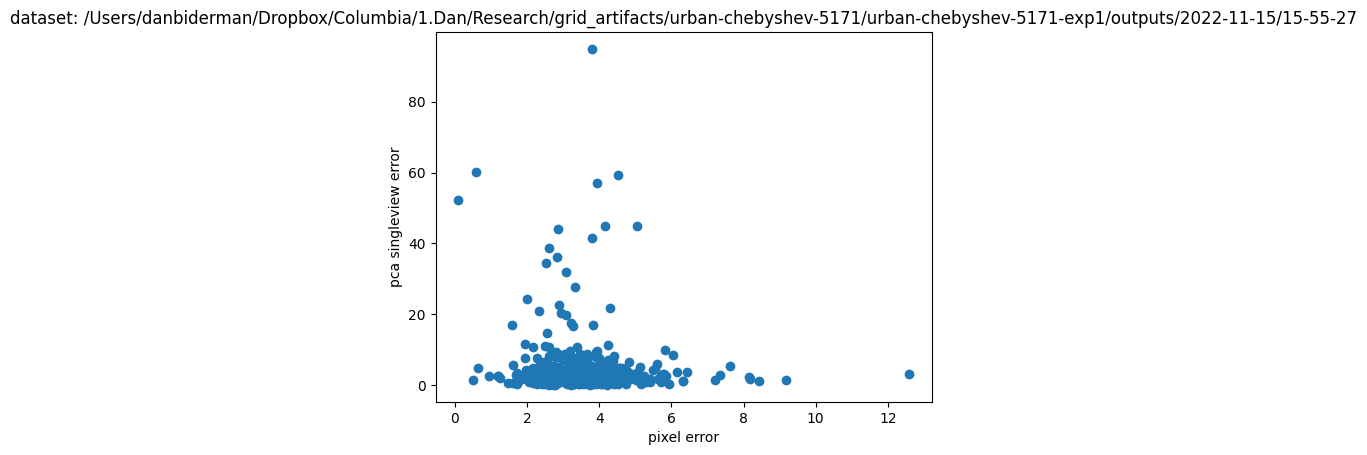

In [17]:
plt.scatter(pixel_error["paw1LH_bot"], pca_sv_error["paw1LH_bot"])
plt.xlabel("pixel error")
plt.ylabel("pca singleview error")
plt.title("dataset: %s" % total_df["path"].iloc[0])

In [9]:
# single combined query
query_1 = query_builder.combine_queries("and")
query_2 = "(`training.rng_seed_data_pt` == '1') or (`training.rng_seed_data_pt` == '2')"
print(query_1)
print(query_2)
combo = f"({query_1}) and ({query_2})"
print(combo)
print(total_df.query(combo))


(`model.losses_to_use` == '[]') and (timestamp >= '2022-11-14' and timestamp <= '2022-11-16')
(`training.rng_seed_data_pt` == '1') or (`training.rng_seed_data_pt` == '2')
((`model.losses_to_use` == '[]') and (timestamp >= '2022-11-14' and timestamp <= '2022-11-16')) and ((`training.rng_seed_data_pt` == '1') or (`training.rng_seed_data_pt` == '2'))
  data.image_orig_dims.height data.image_orig_dims.width  \
0                         406                        396   
0                         406                        396   
0                         406                        396   
0                         406                        396   

  data.image_resize_dims.height data.image_resize_dims.width  \
0                           256                          256   
0                           256                          256   
0                           256                          256   
0                           256                          256   

              data.data_dir 

In [6]:
total_df.query(query_builder.combine_queries("and"))

,data.image_orig_dims.height,data.image_orig_dims.width,data.image_resize_dims.height,data.image_resize_dims.width,data.data_dir,data.video_dir,data.csv_file,data.header_rows,data.downsample_factor,data.num_keypoints,...,eval.confidence_thresh_for_vid,eval.video_file_to_plot,eval.pred_csv_files_to_plot,callbacks.anneal_weight.attr_name,callbacks.anneal_weight.init_val,callbacks.anneal_weight.increase_factor,callbacks.anneal_weight.final_val,callbacks.anneal_weight.freeze_until_epoch,timestamp,path
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:09,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:42,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:32:33,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:36,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:18,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:55,/Users/danbiderman/Dropbox/Columbia/1.Dan/Rese...


In [6]:
queried_df = total_df.query(query_builder.combine_queries("and"))

UndefinedVariableError: local variable 'value' is not defined

In [9]:
queried_df.shape

(6, 96)

In [37]:
print(queried_df.head()["path"].iloc[0])

/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/grid_artifacts/affable-lamport-279/affable-lamport-279-exp15/outputs/2022-07-15/15-28-21


In [8]:
# query if random seed is in list
filter_list = ["0","1","2"]
query = "(`training.rng_seed_data_pt` in @filter_list) and (`model.losses_to_use` == '[]')"
print(query)
total_df.query(query)
#total_df.query("`training.rng_seed_data_pt` in [1,2]")

(`training.rng_seed_data_pt` in @filter_list) and (`model.losses_to_use` == '[]')


,data.image_orig_dims.height,data.image_orig_dims.width,data.image_resize_dims.height,data.image_resize_dims.width,data.data_dir,data.video_dir,data.csv_file,data.header_rows,data.downsample_factor,data.num_keypoints,...,eval.create_labeled_video,eval.confidence_thresh_for_vid,eval.video_file_to_plot,eval.pred_csv_files_to_plot,callbacks.anneal_weight.attr_name,callbacks.anneal_weight.init_val,callbacks.anneal_weight.increase_factor,callbacks.anneal_weight.final_val,callbacks.anneal_weight.freeze_until_epoch,timestamp
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:09
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:42
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:32:33
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:30:36
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:18
0,406,396,256,256,/datastores/mirror-mouse,/datastores/mirror-mouse/videos,CollectedData.csv,"[0, 1, 2]",2,17,...,True,0.05,,[' '],total_unsupervised_importance,0.0,0.01,1.0,0,2022-11-15 11:31:55
